In [78]:
import glob
from djccx.frd.readfrd import readfrd
from matplotlib import pyplot as plt
import numpy as np


In [79]:
frd_files = glob.glob('output/**/*.frd', recursive=True)

In [80]:
frd_files

['output\\f_0\\main.frd',
 'output\\f_1\\main.frd',
 'output\\f_2\\main.frd',
 'output\\f_3\\main.frd']

In [81]:
ifrd = readfrd(frd_files[0])
frd_data = ifrd["data"]

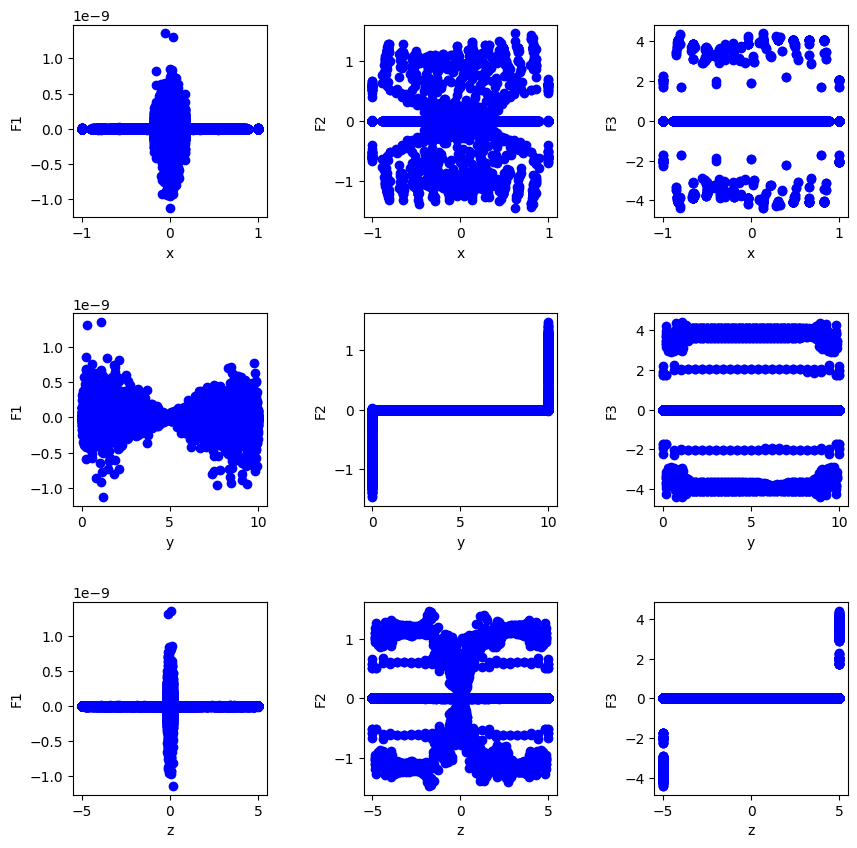

In [82]:
dims = ["x", "y", "z"]
forces = ["F1", "F2", "F3"]

fig = plt.figure()
#set size
fig.set_size_inches(10, 10)
# add padding 
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i, dim in enumerate(dims):
    for j, force in enumerate(forces):
        plt.subplot(3, 3, 3*i+j+1)
        plt.plot(frd_data[dim], frd_data[force], label=f"{dim} {force}",
                 marker='o', 
                 linestyle='none', 
                 color='b')
        plt.xlabel(dim)
        plt.ylabel(force)

In [83]:
def compute_young_eff(frd_path):

    ifrd = readfrd(frd_path)
    frd_data = ifrd["data"]
    z = frd_data["z"]
    zmid = (z.max() + z.min())/2
    force = frd_data["F3"]

    Lx = 2.0
    Ly = 10.0 # lo mas grande posible
    A = Lx*Ly

    Stress = force[z > zmid].sum()/A
    epsilon = 0.1

    return Stress/epsilon

In [84]:
from validation.experimental import carbonfiber,resina,nucleo
carbon_data = carbonfiber()
resina_data = resina()
nucleo_data = nucleo()

Ec_GPa = carbon_data["carbon"]["Young Modulus (GPa)"][0]
Ec = Ec_GPa*1e3
nu_c = carbon_data["poisson ratio"]
Em = nucleo_data["young modulus [MPa]"]
nu_m = nucleo_data["poisson ratio"]

In [85]:

params = {
    "zT": 5,
    "matrix": {
        "E": Em,
        "nu": nu_m
    },
    "carbon": {
        "E": Ec,
        "nu": nu_c
    },
    "output_folder": "output"
}


In [86]:
params

{'zT': 5,
 'matrix': {'E': 800, 'nu': 0.3},
 'carbon': {'E': np.float64(230000.0), 'nu': 0.3},
 'output_folder': 'output'}

In [87]:
z_f_span = np.linspace(0.5, 19, 6)/100 # 0.5% to 10% of the total thicknessz


z_f_span = z_f_span[:len(frd_files)]

In [88]:
def analytical(vfrac_carbon):

    Em = params["matrix"]["E"]
    Ec = params["carbon"]["E"]
    Lx = 2.0
    Lz = 10.0
    l = np.sqrt(Lx*Lz*vfrac_carbon)

    vx = l/Lx
    vz = l/Lz

    E_eff_ast = Ec*vx + Em*(1-vx)

    return 1/( (1-vz)/Em + vz/E_eff_ast)

E_eff_analytical = [analytical(z_f) for z_f in z_f_span]

In [89]:
E_eff = [ compute_young_eff(frd_path) for frd_path in frd_files]


In [90]:
from matplotlib import pyplot as plt

(0.0, 1025.1658792346668)

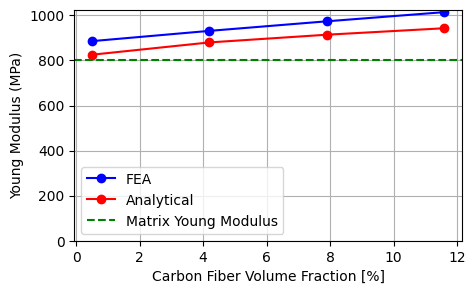

In [91]:
fig = plt.figure()
fig.set_size_inches(5, 3)

plt.plot(100*z_f_span, E_eff, marker='o', linestyle='-', color='b', label='FEA')
plt.plot(100*z_f_span, E_eff_analytical, marker='o', linestyle='-', color='r', label='Analytical')
# horizontal line in Em and Ec
Em = params["matrix"]["E"]
Ec = params["carbon"]["E"]
plt.axhline(y=Em, color='g', linestyle='--', label='Matrix Young Modulus')
# plt.axhline(y=Ec, color='k', linestyle='--', label='Carbon Young Modulus')
# mpa
plt.ylabel('Young Modulus (MPa)')
plt.xlabel('Carbon Fiber Volume Fraction [%]')
plt.legend()
# from 0 to max 
#plt.ylim(0, np.max(E_eff_analytical)*1.1)
plt.grid()
plt.ylim([0,None])

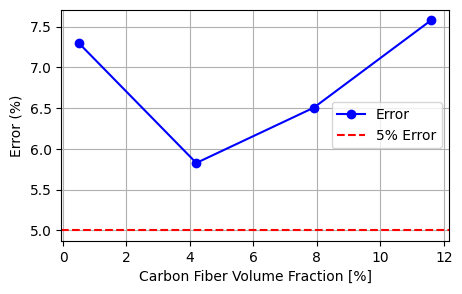

In [92]:

# error 
error = 100*np.abs(np.array(E_eff) - np.array(E_eff_analytical))/np.array(E_eff_analytical)

fig = plt.figure()
fig.set_size_inches(5, 3)

plt.plot(100*z_f_span, error, marker='o', linestyle='-', color='b', label='Error')
# horizontal 5%
plt.axhline(y=5, color='r', linestyle='--', label='5% Error')
plt.ylabel('Error (%)')
plt.xlabel('Carbon Fiber Volume Fraction [%]')
plt.grid()
plt.legend()